<a href="https://www.kaggle.com/code/gpreda/rag-system-using-gemma-2-langchain-and-chromadb?scriptVersionId=206111330" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<center><h1>RAG using Gemma 2, Langchain and ChromaDB</h1></center>
<center>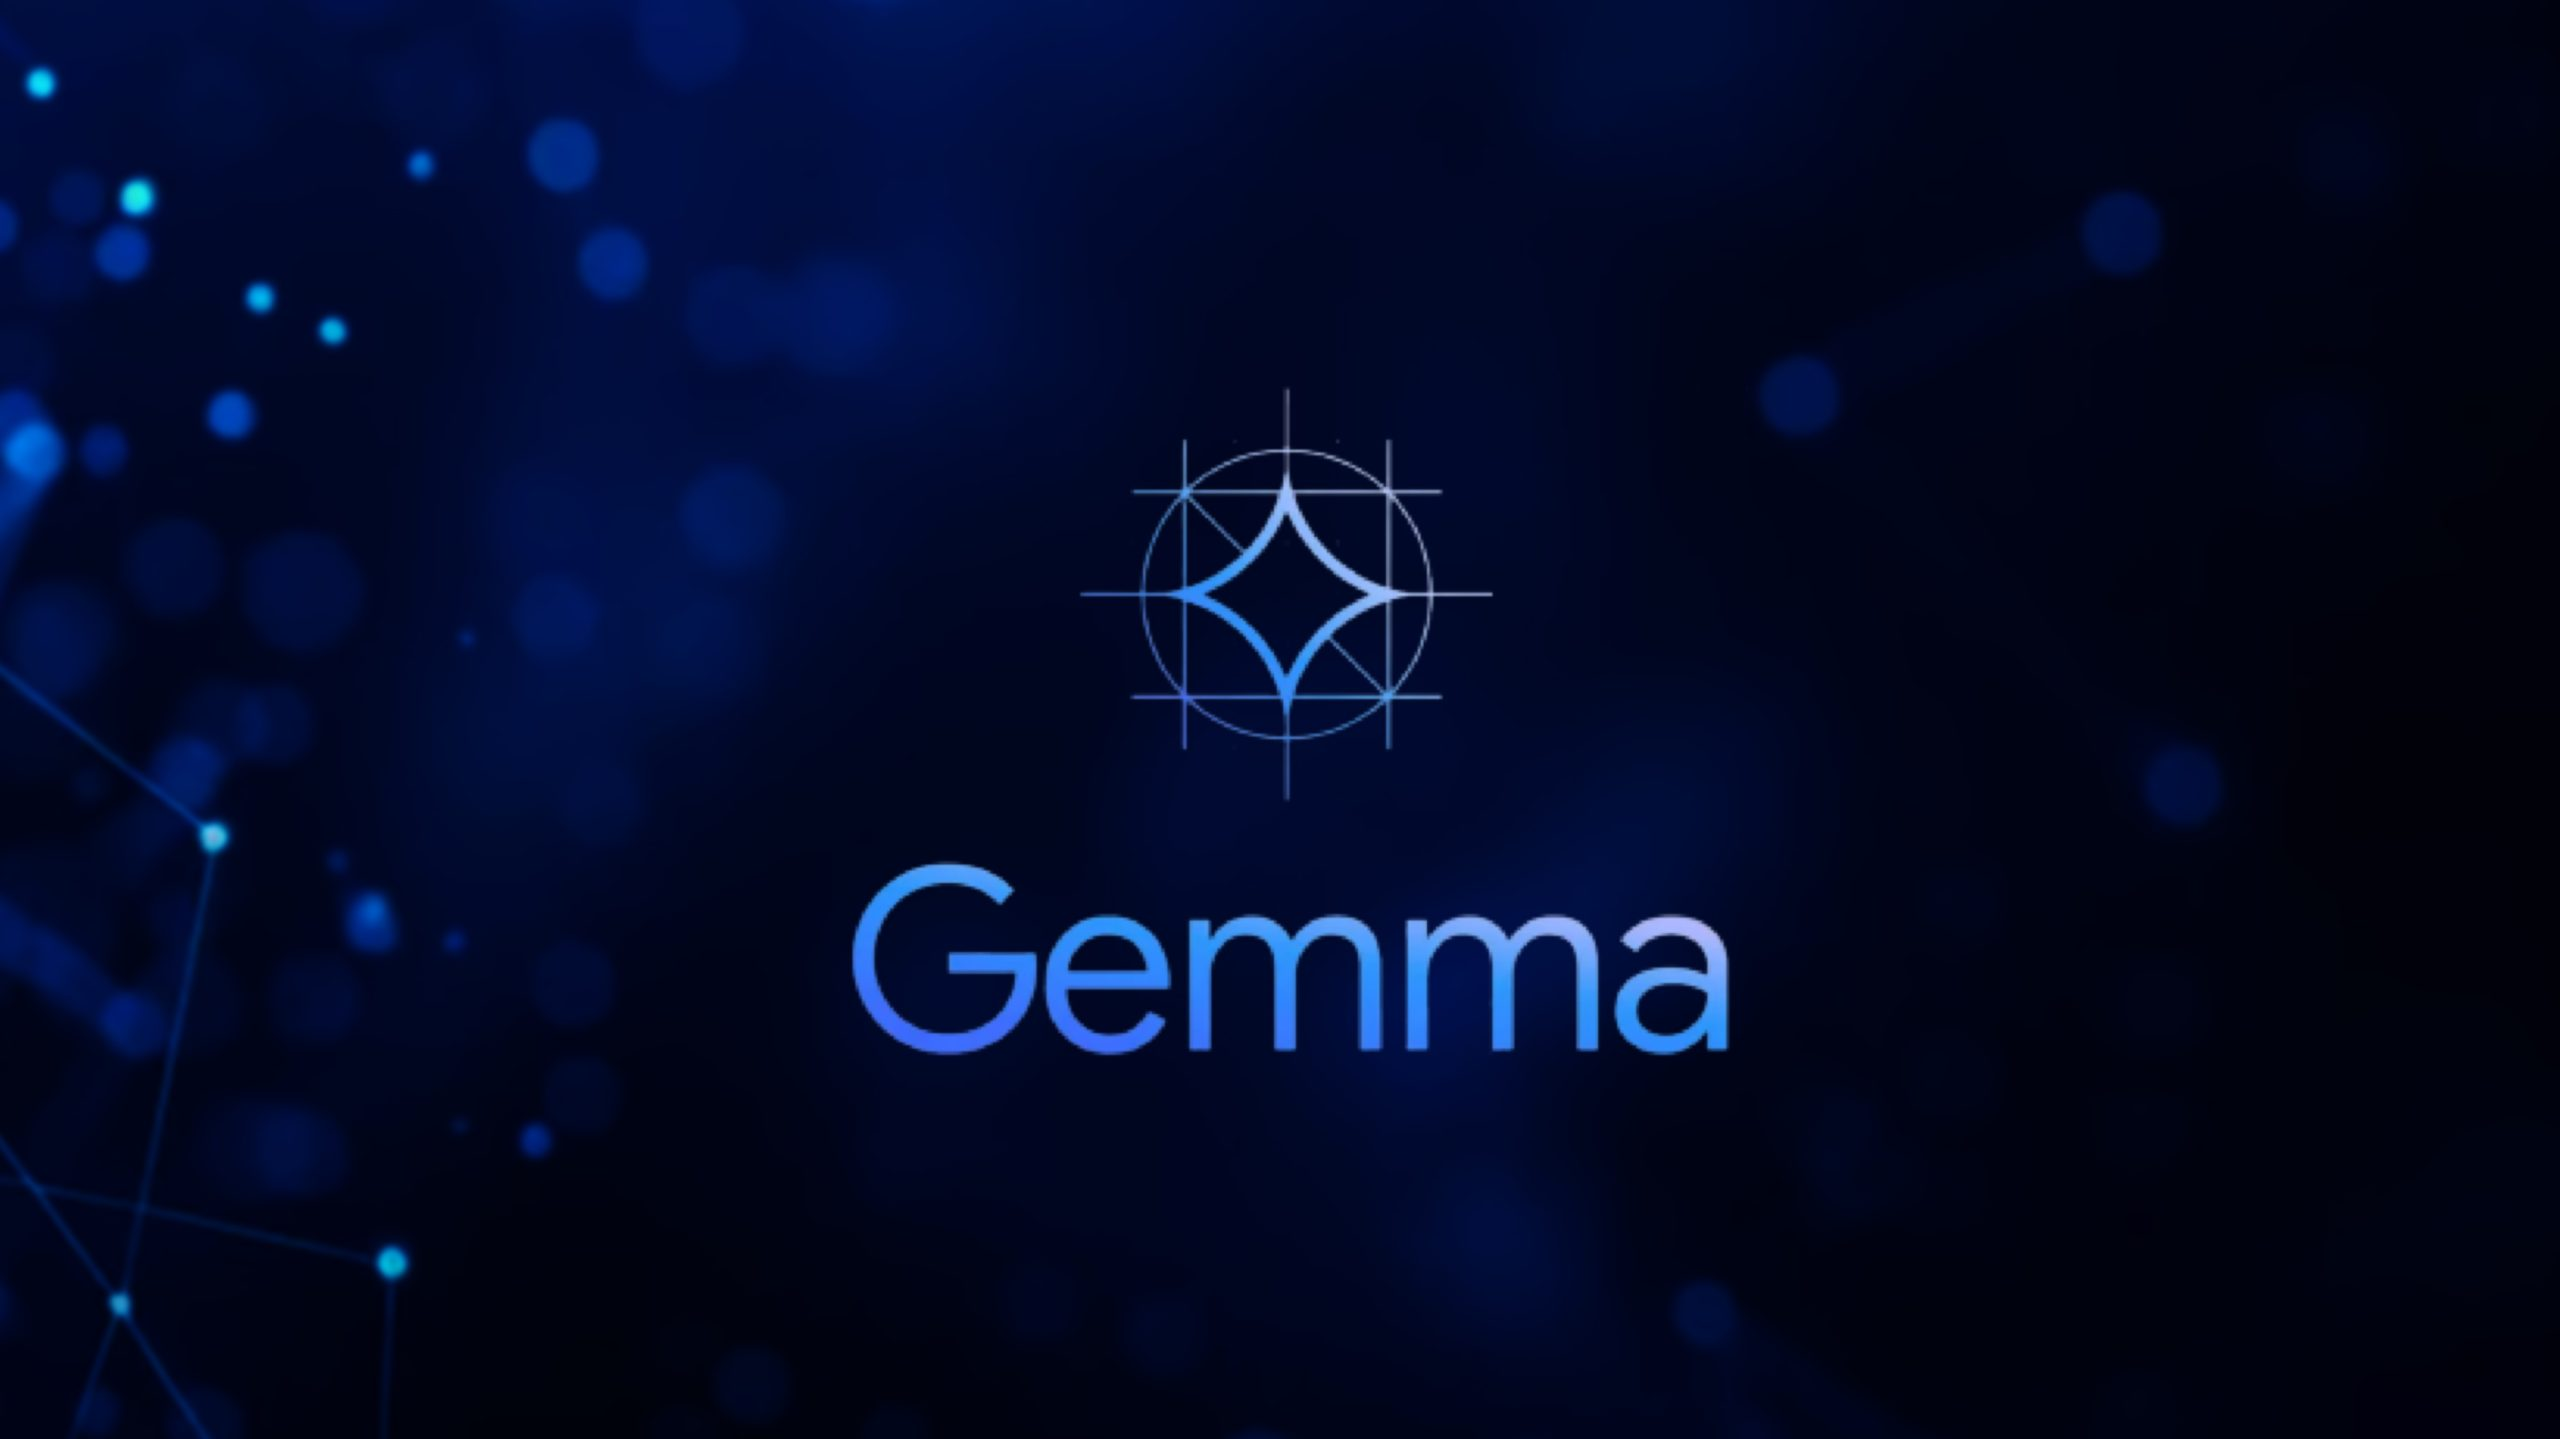</center>


# Introduction

This notebook demonstrates how to build a retrieval augmented generation (RAG) system using **Gemma 2** as a large language model (LLM), Langchain for tools to process input files, and ChromaDB as vector database.

## What is RAG?

Retriever augmented generation (RAG) is a system that improves the response generated by a LLM in two ways:
- First, the information is retrieved from a dataset that is stored in vector database; the query is used to perform similarity search in the documents stored in the vector database.
- Second, by restraining the context provided to the LLM to content that is similar with the initial query, stored in the vector database, we can reduce significantly (or even eliminate) LLM's halucinations, since the answer is provided from the context of the stored documents.

An important advantage of this approach is that we do not need to fine-tune the LLM with our custom data; instead, the data is ingested (cleaned, transformed, chunked, and indexed in the vector database).

## Procedure

We create two classes:
* **AIAgent** - An AI Agent that query **Gemma 2** LLM using a custom prompt that instruct Gemma to generate and answer (from the query) by refering to the context (as well provided); the answer to the AI Agent query function is then returned.
* **RAGSystem** - initialized with the dataset with Data Science information, with an AIAgent object. In the init function of this class, we ingest the data from the dataset in the vector database. This class have as well a query member function. In this function we first perform similarity search with the query to the vector database. Then, we call the generate function of the ai agent object. Before returning the answer, we use a predefined template to compose the overal response from the question, answer and the context retrieved.


# Packages instalation and configurations

In [1]:
# install required libraries
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes
!pip install langchain
!pip install sentence-transformers
!pip install chromadb

Looking in indexes: https://pypi.org/simple/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.7/306.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_

In [2]:
!pip install -U langchain-community

  Using cached pydantic-2.9.2-py3-none-any.whl.metadata (149 kB)
  Using cached pydantic_core-2.23.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.6 MB/s eta 0:00:00
Using cached pydantic-2.9.2-py3-none-any.whl (434 kB)
Using cached pydantic_core-2.23.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 MB)
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.16.3
    Uninstalling pydantic_core-2.16.3:
      Successfully uninstalled pydantic_core-2.16.3
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.6.4
    Uninstalling pydantic-2.6.4:
      Successfully uninstalled pydantic-2.6.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM

from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma

from IPython.display import display, Markdown


# Test Gemma 2 2b without added context

We will index into a vector database (for the retrieval part of the RAG system) the text from one Romanian literature classical book. First, let's see if Gemma 2 know to answer to questions from this book. We will ask rather obscure questions.  

Let's create a function to query Gemma 2. We will later reuse this code to build an AIAgent class. 



In [4]:
max_length = 256
model_id = "/kaggle/input/gemma-2/transformers/gemma-2-2b-it/2"
tokenizer = AutoTokenizer.from_pretrained(model_id)
gemma_lm = AutoModelForCausalLM.from_pretrained(model_id)

2024-11-09 10:49:13.915616: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-09 10:49:13.915734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-09 10:49:14.186020: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
def query_gemma(prompt):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    answer = gemma_lm.generate(
        input_ids,
        max_new_tokens=max_length
    )
    answer = tokenizer.decode(answer[0], skip_special_tokens=True, skip_prompt=True)
    return answer

In [6]:
answer = query_gemma("Unde s-a născut Bârzof?")
print(answer)

Unde s-a născut Bârzof?

Bârzof s-a născut în **România**. 



This is not the answer we were expecting. Let's start to build our RAG system.

In [7]:
import gc
del tokenizer, gemma_lm
gc.collect()

138

# AI Agent class

In [8]:
class AIAgent:
    """
    Gemma 2b-it assistant.
    It uses Gemma 2 transformers 2b-it/2.
    """
    def __init__(self, max_length=256):
        self.max_length = max_length
        self.model_id = "/kaggle/input/gemma-2/transformers/gemma-2-2b-it/2"
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_id)
        self.gemma_lm = AutoModelForCausalLM.from_pretrained(self.model_id)

    def create_prompt(self, query, context):
        # prompt template
        prompt = f"""
            Ești un agent specializat să raspundă la întrebări din contextul furnizat.
            Răspunde succint, în limba română, și nu folosi
            alte informații pentru a raspunde decat cele din context.
            Intrebare: {query}
            Context: {context}
            Răspuns:
        """
        return prompt
    
    def generate(self, query, retrieved_info):
        prompt = self.create_prompt(query, retrieved_info)
        input_ids = self.tokenizer(prompt, return_tensors="pt").input_ids
        # Answer generation
        answer = self.gemma_lm.generate(
            input_ids,
            max_new_tokens=self.max_length
        )
        # Decode and return the answer
        answer = self.tokenizer.decode(answer[0], skip_special_tokens=True, skip_prompt=True)
        return prompt, answer

## Test the AIAgent


We will test now the AI agent with a context that we inject programatically.   

Later, we will provide the context using the retrieval component of the retrieval augmented generation system.  

We want to test now how accurate is the generation part, provided that the context contains the  information we are querying about.  

In the following code sections, we will inject information of a certain **Bârzof** who used to live in Bugeac and we will ask the **AIAgent** about where he used to live.


In [9]:
ai_agent = AIAgent()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
context = """
Auzit-ai de unul Bârzof? Dacă n-ai auzit, eu să-ți spui cine și ce era; căci l-am văzut și l-am auzit cu ochii și cu urechile mele.
Bârzof era, cum zice românul, un om cât un munte: înalt, gros și chipeș, ochi mititei în fundul capului, umerii obrazului scoși și nasul numai o fărâmiță de sfârc: tipul de mongol cel mai bine caracterizat. După celealalte toate, era și ciupit de vărsat, și ciupit așa de adânc, că în fiecare gropiță se putea ascunde bobul de mazăre.
Născut în Bugeag, fusese însă crescut printre românii de pe malul drept al Bugului, unde tată-său a fost ani mulți cinovnic la spirtoase și vorbea românește ca apa. Intrat de copil ca piser în cancelaria poliției, ajunsese nacealnic și dobândise cinul de calejki savetnik, încât, când îi vorbeai, trebuia să-i zici cu respect 'Vasi-visoko-blagorodie'. El când vorbea începea cu: 'Ștotakoi?'... și încheia cu 'Durak Moldavan! ptiuuu!' în obraz. "
"""
print("Context: ", context)
prompt, answer = ai_agent.generate(query="Unde s-a nascut Bârzof?", retrieved_info=context)
print("LLM Answer: ", answer)

Context:  
Auzit-ai de unul Bârzof? Dacă n-ai auzit, eu să-ți spui cine și ce era; căci l-am văzut și l-am auzit cu ochii și cu urechile mele.
Bârzof era, cum zice românul, un om cât un munte: înalt, gros și chipeș, ochi mititei în fundul capului, umerii obrazului scoși și nasul numai o fărâmiță de sfârc: tipul de mongol cel mai bine caracterizat. După celealalte toate, era și ciupit de vărsat, și ciupit așa de adânc, că în fiecare gropiță se putea ascunde bobul de mazăre.
Născut în Bugeag, fusese însă crescut printre românii de pe malul drept al Bugului, unde tată-său a fost ani mulți cinovnic la spirtoase și vorbea românește ca apa. Intrat de copil ca piser în cancelaria poliției, ajunsese nacealnic și dobândise cinul de calejki savetnik, încât, când îi vorbeai, trebuia să-i zici cu respect 'Vasi-visoko-blagorodie'. El când vorbea începea cu: 'Ștotakoi?'... și încheia cu 'Durak Moldavan! ptiuuu!' în obraz. "

LLM Answer:  
            Ești un agent specializat să raspundă la întrebăr

The AIAgent answered correctly, according to the text, that the named Bârzov used to live in Bugeac.

Let's progress with our work, and build the RAG system.

# RAGSystem class


We define now the **RAGSystem** class. 

In the init member function, this class initializes:
* the number of documents to retrieve upon querying the system,
* the AIAgent object to work with (which will fulfil the role of generator),
* the loader for the documents indexed in the vector database,
* the predefined template we will use to compose the query.

In the same init function, documents are loaded, converted to text, splitted in chunks (with partial overlaping), then the chunks are indexed in the vector database. For this proof of concept, a ChromaDB is used.  

In the retrieve member function, we run the retrieval part of the RAG.  

In the query member function, the following operations are done:
- Call retrieve member function,  
- Build the context from the output of retrieve function,  
- Call the generate member function of AIAgent object with the query text and the context as parameters.

In [11]:
class RAGSystem:
    """Sentence embedding based Retrieval Based Augmented generation.
        Given database of pdf files, retriever finds num_retrieved_docs relevant documents"""
    def __init__(self, ai_agent, num_retrieved_docs=2):
        # load the data
        self.num_docs = num_retrieved_docs
        self.ai_agent = ai_agent
        loader = PyPDFLoader("/kaggle/input/scrisori-ctre-vasile-alecsandri-de-ion-ghica/Scrisori_catre_Vasile_Alecsandri.pdf")
        documents = loader.load()
        self.template = "\n\nIntrebare:\n{question}\n\nRăspuns:\n{answer}\n\nContext:\n{context}"
        
        
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=800, 
            chunk_overlap=100)
        all_splits = text_splitter.split_documents(documents)
        # create a vectorstore database
        embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
        self.vector_db = Chroma.from_documents(documents=all_splits, 
                                               embedding=embeddings, 
                                               persist_directory="chroma_db")
        self.retriever = self.vector_db.as_retriever()

    def retrieve(self, query):
        # retrieve top k similar documents to query
        docs = self.retriever.get_relevant_documents(query)
        return docs
    
    def query(self, query):
        # generate the answer
        context = self.retrieve(query)
        data = ""
        for item in list(context):
            data += item.page_content
            
        prompt, answer = self.ai_agent.generate(query, data)
        
        return self.template.format(question=query,
                                    #prompt=prompt,
                                   answer=answer,
                                   context=context)
        
        

We will also add a function to beautify the answer from the RAG system, to show separatelly the prompt, the context, and the answer.

In [12]:
def colorize_text(text):
    for word, color in zip(["Intrebare", "Prompt", "Răspuns", "Context"], ["blue", "magenta", "red", "green"]):
        #text = text.replace(f"\n\n{word}:", f"\n\n**<font color='{color}'>{word}:</font>**")
        text = text.replace(f" {word}:", f"\n\n**<font color='{color}'>{word}:</font>**")
    return text

## Test the RAG system

First, we initialize a RAGSystem object.

In [13]:
rag_system = RAGSystem(ai_agent)

/tmp/ipykernel_26/125177683.py:18: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Let's try first with few of the questions from the data we used for the retrieval system.

In [14]:
answer = rag_system.query("Cine a fost Bârzof?")
display(Markdown(colorize_text(answer)))

/tmp/ipykernel_26/125177683.py:26: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = self.retriever.get_relevant_documents(query)




Intrebare:
Cine a fost Bârzof?

Răspuns:

            Ești un agent specializat să raspundă la întrebări din contextul furnizat.
            Răspunde succint, în limba română, și nu folosi
            alte informații pentru a raspunde decat cele din context.
           

**<font color='blue'>Intrebare:</font>** Cine a fost Bârzof?
           

**<font color='green'>Context:</font>** 384băiețel cu o pernă mare de catifea roșie în cap, cât dânsul de
înaltă, mâna caii d-a-n picioarele, strigând întruna cu glas
ascuțit și prelungit: 'Padii!'..., de fugea lumea de se
prăpădea, căci T imofei nu căta peste ce da. Când trecea pe
uliță, auzeai pe bieții creștini vestindu-se unii pe alții cu:
'Fugi, mă, că trece căruțul lui sfântu Ilie'. Era totdauna
urmat de trei-patru cazaci de Don, plecați pe cai, cu sulițele
înainte ca la bătălie, și băteau de zvântau, căci Bârzof era
polițai nacealnic.
Mi-l aduc aminte când a venit acasă la noi. Cum a ajuns la
scară, a descălicat de pe scândură și s-a suit în fugă pe
scară, zdrăngănind sabia de toate treptele; cum a găsit pe
tata, i-a dat în mână un plic cu o pecete mare roșie. T ata,
după ce a citit scrisoarea, îi zise:305guvernorului misiunea cu care veneam, el mi-a declarat că
răspunderea sa încetînd, voiește să rămîie pe bordul vasului
pe care ne aflam, dar observîndu-i că răspunderea sa nu
putea înceta decît după ce-i voi remite scrisorile, pe care nu
i le voi da decît în localul guvernorului, l-am obligat să
dezbarce împreună cu mine. Îndată ce am pus piciorul pe
uscat, am fost înconjurați de mulțime; atunci, zărind un
preot bătrîn, m-am dus drept către dînsul, salutîndu-l
respectuos, și i-am cerut să-mi arate unde era Mitropolia.
Într-o clipă, biserica a fost plină, și preotul, punîndu-și
odăjdiile, a citit rugăciunile de bună-venire, ceea ce a fost
de un bun efect, dovedind locuitorilor că eram un
coreligionar .
Am rămas de prînz la predecesorul meu, împreună cu cei87Țin mult dar , foarte mult, a nu-ți spune decât ceea ce a fost
și așa cum a fost. Mai bine trec cu tăcerea sau îmi frâng
pana decât să laud vitejiile și virtuțile unui om care n-a fost
decât o secătură, sau să înnegresc pe cineva pentru că nu
mi-a plăcut ochii săi sau pentru că ai mei nu au avut
norocirea să-i placă lui.
Este și păcat a pune pe lume să citească ceea ce n-a fost. Un
turist care a petrecut câteva săptămâni în București se
deșteaptă peste câteva zecimi de ani și vrea să-și plătească
datoria de recunoștință pentru ospitalitatea ce primise;
apucă condeiul de coadă și spune, coloane întregi, că d-l X
... era un om de spirit, învățat, plin de talent, model de
devotament și de patriotism; că moștenise toate virtuțile
cerești și pământești de la moșii și strămoșii lui; pe cândEmoțiunile cocoanelor erau la aceste lupte tot atât de vii ca
și ale damelor spaniole la luptele de los toros.
Alecu Ghica Barbă-Roșie avea pe Bercea, un câne-lup cu
coada și urechile tăiete din rădăcină, dobitoc fioros și rău,
care sta ziua și noaptea culcat la ușa lui stăpânu-său,
dormind numai dintr -un ochi. Pe mulți a mai speriat, pe
mulți a mai mușcat și la mulți a rupt din carne fiorosul
Bercea. La asemenea întâmplări, Barbă-Roșie cădea cu
dojana tot pe bietul pățit cu: 'Na! bine ți-a făcut, neghiobule,
dacă nu-l lași în pace!', deși omului nici prin gând nu-i
trecuse să-l atingă sau să-l ațâțe. Bercea nu s-a putut împăca
nicidecum cu muscalii; sărea la ei când îi vedea trecând pe
la poartă, așa că într -o zi, luându-se la harță cu trei soldați, a
           

**<font color='red'>Răspuns:</font>**
        Bârzof era un polițai.


Context:
[Document(metadata={'page': 383, 'source': '/kaggle/input/scrisori-ctre-vasile-alecsandri-de-ion-ghica/Scrisori_catre_Vasile_Alecsandri.pdf'}, page_content="384băiețel cu o pernă mare de catifea roșie în cap, cât dânsul de\nînaltă, mâna caii d-a-n picioarele, strigând întruna cu glas\nascuțit și prelungit: 'Padii!'..., de fugea lumea de se\nprăpădea, căci T imofei nu căta peste ce da. Când trecea pe\nuliță, auzeai pe bieții creștini vestindu-se unii pe alții cu:\n'Fugi, mă, că trece căruțul lui sfântu Ilie'. Era totdauna\nurmat de trei-patru cazaci de Don, plecați pe cai, cu sulițele\nînainte ca la bătălie, și băteau de zvântau, căci Bârzof era\npolițai nacealnic.\nMi-l aduc aminte când a venit acasă la noi. Cum a ajuns la\nscară, a descălicat de pe scândură și s-a suit în fugă pe\nscară, zdrăngănind sabia de toate treptele; cum a găsit pe\ntata, i-a dat în mână un plic cu o pecete mare roșie. T ata,\ndupă ce a citit scrisoarea, îi zise:"), Document(metadata={'page': 304, 'source': '/kaggle/input/scrisori-ctre-vasile-alecsandri-de-ion-ghica/Scrisori_catre_Vasile_Alecsandri.pdf'}, page_content='305guvernorului misiunea cu care veneam, el mi-a declarat că\nrăspunderea sa încetînd, voiește să rămîie pe bordul vasului\npe care ne aflam, dar observîndu-i că răspunderea sa nu\nputea înceta decît după ce-i voi remite scrisorile, pe care nu\ni le voi da decît în localul guvernorului, l-am obligat să\ndezbarce împreună cu mine. Îndată ce am pus piciorul pe\nuscat, am fost înconjurați de mulțime; atunci, zărind un\npreot bătrîn, m-am dus drept către dînsul, salutîndu-l\nrespectuos, și i-am cerut să-mi arate unde era Mitropolia.\nÎntr-o clipă, biserica a fost plină, și preotul, punîndu-și\nodăjdiile, a citit rugăciunile de bună-venire, ceea ce a fost\nde un bun efect, dovedind locuitorilor că eram un\ncoreligionar .\nAm rămas de prînz la predecesorul meu, împreună cu cei'), Document(metadata={'page': 86, 'source': '/kaggle/input/scrisori-ctre-vasile-alecsandri-de-ion-ghica/Scrisori_catre_Vasile_Alecsandri.pdf'}, page_content='87Țin mult dar , foarte mult, a nu-ți spune decât ceea ce a fost\nși așa cum a fost. Mai bine trec cu tăcerea sau îmi frâng\npana decât să laud vitejiile și virtuțile unui om care n-a fost\ndecât o secătură, sau să înnegresc pe cineva pentru că nu\nmi-a plăcut ochii săi sau pentru că ai mei nu au avut\nnorocirea să-i placă lui.\nEste și păcat a pune pe lume să citească ceea ce n-a fost. Un\nturist care a petrecut câteva săptămâni în București se\ndeșteaptă peste câteva zecimi de ani și vrea să-și plătească\ndatoria de recunoștință pentru ospitalitatea ce primise;\napucă condeiul de coadă și spune, coloane întregi, că d-l X\n... era un om de spirit, învățat, plin de talent, model de\ndevotament și de patriotism; că moștenise toate virtuțile\ncerești și pământești de la moșii și strămoșii lui; pe când'), Document(metadata={'page': 386, 'source': '/kaggle/input/scrisori-ctre-vasile-alecsandri-de-ion-ghica/Scrisori_catre_Vasile_Alecsandri.pdf'}, page_content="Emoțiunile cocoanelor erau la aceste lupte tot atât de vii ca\nși ale damelor spaniole la luptele de los toros.\nAlecu Ghica Barbă-Roșie avea pe Bercea, un câne-lup cu\ncoada și urechile tăiete din rădăcină, dobitoc fioros și rău,\ncare sta ziua și noaptea culcat la ușa lui stăpânu-său,\ndormind numai dintr -un ochi. Pe mulți a mai speriat, pe\nmulți a mai mușcat și la mulți a rupt din carne fiorosul\nBercea. La asemenea întâmplări, Barbă-Roșie cădea cu\ndojana tot pe bietul pățit cu: 'Na! bine ți-a făcut, neghiobule,\ndacă nu-l lași în pace!', deși omului nici prin gând nu-i\ntrecuse să-l atingă sau să-l ațâțe. Bercea nu s-a putut împăca\nnicidecum cu muscalii; sărea la ei când îi vedea trecând pe\nla poartă, așa că într -o zi, luându-se la harță cu trei soldați, a")]

In [15]:
answer = rag_system.query("Cine a fost Marin Serghiescu?")
display(Markdown(colorize_text(answer)))



Intrebare:
Cine a fost Marin Serghiescu?

Răspuns:

            Ești un agent specializat să raspundă la întrebări din contextul furnizat.
            Răspunde succint, în limba română, și nu folosi
            alte informații pentru a raspunde decat cele din context.
           

**<font color='blue'>Intrebare:</font>** Cine a fost Marin Serghiescu?
           

**<font color='green'>Context:</font>** 73de-i cânta cântece de lume. Când Grigorie Ghica s-a făcut
domn, Nicolae Alexandrescu a ajuns cafegi-bașa.
Pe Marin Ser ghiescu l-a luat Alecache V illara cântăreț la
Biserica Negustorilor , l-a primblat pe dânsul pe la
Petersbur g, cu Regulamentul; dar mai pe urmă, molipsindu-
se de boala patriotismului, a fost arestat cu Mitică Filipescu,
cu Nicolae Bălcescu și cu T elegescu, trimis la ocnă, unde
și-a spășit păcatele șapte ani, până când a venit de l-a scos
revoluția din patruzeci și opt, ca să-i procure dulcile fericiri
ale unei proscripțiuni de zece ani. El a fost cunoscut mai
mult sub numele de Marin Naționalu. V odă Cuza îl iubea, îl
avea adesea la masă și-l mângâia cu numele de moș Marin.
Când a venit în București dascălul Lazăr , băieții de la51 1ce am făcut acum vreo câțiva ani unui poet de curte de
atunci, pe care-l povățuiam cu versurile:
Ia-ți nădragii de atlas
De-ți fă steagul la Parnas!
Apoi ce fac eu cu acele versuri când voi îmbrăca nădragii
de atlas?'
Mai târziu a fost numit director la Departamentul Credinței,
pe când moșiile mănăstirilor închinate și neînchinate se
arendau cum da Domnul, post important și ambiționat de
toți acei cari căuta să facă averi mari. El, care l-a ocupat
atâți ani, a ieșit de acolo sărac precum intrase.
În anul 1853 se auzea de război. Alexandrescu, ca și Nicu
Bălcescu au avut totdeauna credința că România numai prin
arme se putea ridica la rangul ce i se cuvine. Era vorba ca o
armată auxiliară franceză să vie să ocupe valea Dunărei de154Iar Marin Ser ghiescu (Naționalu) se uita cu milă la dînsul,
zicînd:
— Perotule, perotule! Săracule! tu nu ai patrie, tu nu știi ce
e cîntecul național.
Aceste puține cuvinte, zise cum au putut fi zise, ne-au făcut
pe toți să ne podidească lacrimile.
Acești oameni nu simt românește, nu le place nimica
românesc. Noi ăștia get-beget coada vacii, născuți, crescuți
și îmbătrîniți în țara asta, care am văzut-o fărimicată și
umilită, pe cînd pașa de la Diu și Silistra-valesi făcea să
tremure domnii noștri; pe cînd un Zaltukin azvîrlea pe
boieri cu brînci pe scară și sur ghiunea mitropoliții; pe cînd
un Bezak ș-un Rukman insulta pe domni pe tronul lor și
dictau legi țării; pe cînd, ca să ne ducem cu lînă, cu piei, cu
miere sau cu unt peste graniță sau peste Dunăre, ne trebuia547Guvernul începu a fi neliniștit și cugeta a face arestări; dar ,
viind aga Iancu Manu în sfatul domnesc cu propunerea să
aresteze trei inși, și anume, pe C.A. Rosetti, pe Grigorie
Scarlat Grădișteanu și pe Ion Ghica, se scoală Costache
Cornescu, logofătul bisericesc (ministru cultelor), și zice că
era de prisos să aresteze pe nepotul său Ruset, căci nu mai
putea fi primejdios, fiind gata să plece la Paris. Atunci un
alt membru al sfatului, Grigorie Grădișteanu, zice că el nu
admite escepțiuni și că ori să se aresteze câte trei sau nici
unul, căci dacă era să se facă favoruri, atunci va cere și el
escepțiune pentru nepotul său, Grigorie Sc. Grădișteanu,
căruia și lui i-ar fi mai plăcut a se plimba pe ulițele
Parisului decât a sta închis la gros.
           

**<font color='red'>Răspuns:</font>**
        Marin Serghiescu a fost un cântăreț, poet și politician român.
        A fost cunoscut sub numele de Marin Naționalu.
        A fost director la Departamentul Credinței și a fost arestat pentru patriotismul său.
        A fost arestat cu Nicolae Bălcescu și cu T elegescu.
        A fost arestat cu Mitică Filipescu.
        A fost arestat cu Nicolae Alexandrescu.
        A fost arestat pentru patriotismul său.
        A fost arestat pentru patriotismul său.
        A fost arestat pentru patriotismul său.
        A fost arestat pentru patriotismul său.
        A fost arestat pentru patriotismul său.
        A fost arestat pentru patriotismul său.
        A fost arestat pentru patriotismul său.
        A fost arestat pentru patriotismul său.
        A fost arestat pentru patriotismul său.
        A fost arestat pentru patriotismul său.
        A fost arestat pentru patriotismul său.
        A fost arestat pentru patriotismul său.
        A fost arestat pentru patriotismul său.


Context:
[Document(metadata={'page': 72, 'source': '/kaggle/input/scrisori-ctre-vasile-alecsandri-de-ion-ghica/Scrisori_catre_Vasile_Alecsandri.pdf'}, page_content='73de-i cânta cântece de lume. Când Grigorie Ghica s-a făcut\ndomn, Nicolae Alexandrescu a ajuns cafegi-bașa.\nPe Marin Ser ghiescu l-a luat Alecache V illara cântăreț la\nBiserica Negustorilor , l-a primblat pe dânsul pe la\nPetersbur g, cu Regulamentul; dar mai pe urmă, molipsindu-\nse de boala patriotismului, a fost arestat cu Mitică Filipescu,\ncu Nicolae Bălcescu și cu T elegescu, trimis la ocnă, unde\nși-a spășit păcatele șapte ani, până când a venit de l-a scos\nrevoluția din patruzeci și opt, ca să-i procure dulcile fericiri\nale unei proscripțiuni de zece ani. El a fost cunoscut mai\nmult sub numele de Marin Naționalu. V odă Cuza îl iubea, îl\navea adesea la masă și-l mângâia cu numele de moș Marin.\nCând a venit în București dascălul Lazăr , băieții de la'), Document(metadata={'page': 510, 'source': '/kaggle/input/scrisori-ctre-vasile-alecsandri-de-ion-ghica/Scrisori_catre_Vasile_Alecsandri.pdf'}, page_content="51 1ce am făcut acum vreo câțiva ani unui poet de curte de\natunci, pe care-l povățuiam cu versurile:\nIa-ți nădragii de atlas\nDe-ți fă steagul la Parnas!\nApoi ce fac eu cu acele versuri când voi îmbrăca nădragii\nde atlas?'\nMai târziu a fost numit director la Departamentul Credinței,\npe când moșiile mănăstirilor închinate și neînchinate se\narendau cum da Domnul, post important și ambiționat de\ntoți acei cari căuta să facă averi mari. El, care l-a ocupat\natâți ani, a ieșit de acolo sărac precum intrase.\nÎn anul 1853 se auzea de război. Alexandrescu, ca și Nicu\nBălcescu au avut totdeauna credința că România numai prin\narme se putea ridica la rangul ce i se cuvine. Era vorba ca o\narmată auxiliară franceză să vie să ocupe valea Dunărei de"), Document(metadata={'page': 153, 'source': '/kaggle/input/scrisori-ctre-vasile-alecsandri-de-ion-ghica/Scrisori_catre_Vasile_Alecsandri.pdf'}, page_content='154Iar Marin Ser ghiescu (Naționalu) se uita cu milă la dînsul,\nzicînd:\n— Perotule, perotule! Săracule! tu nu ai patrie, tu nu știi ce\ne cîntecul național.\nAceste puține cuvinte, zise cum au putut fi zise, ne-au făcut\npe toți să ne podidească lacrimile.\nAcești oameni nu simt românește, nu le place nimica\nromânesc. Noi ăștia get-beget coada vacii, născuți, crescuți\nși îmbătrîniți în țara asta, care am văzut-o fărimicată și\numilită, pe cînd pașa de la Diu și Silistra-valesi făcea să\ntremure domnii noștri; pe cînd un Zaltukin azvîrlea pe\nboieri cu brînci pe scară și sur ghiunea mitropoliții; pe cînd\nun Bezak ș-un Rukman insulta pe domni pe tronul lor și\ndictau legi țării; pe cînd, ca să ne ducem cu lînă, cu piei, cu\nmiere sau cu unt peste graniță sau peste Dunăre, ne trebuia'), Document(metadata={'page': 546, 'source': '/kaggle/input/scrisori-ctre-vasile-alecsandri-de-ion-ghica/Scrisori_catre_Vasile_Alecsandri.pdf'}, page_content='547Guvernul începu a fi neliniștit și cugeta a face arestări; dar ,\nviind aga Iancu Manu în sfatul domnesc cu propunerea să\naresteze trei inși, și anume, pe C.A. Rosetti, pe Grigorie\nScarlat Grădișteanu și pe Ion Ghica, se scoală Costache\nCornescu, logofătul bisericesc (ministru cultelor), și zice că\nera de prisos să aresteze pe nepotul său Ruset, căci nu mai\nputea fi primejdios, fiind gata să plece la Paris. Atunci un\nalt membru al sfatului, Grigorie Grădișteanu, zice că el nu\nadmite escepțiuni și că ori să se aresteze câte trei sau nici\nunul, căci dacă era să se facă favoruri, atunci va cere și el\nescepțiune pentru nepotul său, Grigorie Sc. Grădișteanu,\ncăruia și lui i-ar fi mai plăcut a se plimba pe ulițele\nParisului decât a sta închis la gros.')]

In [16]:
answer = rag_system.query("Cât de mare era curtea banului Ghica?")
display(Markdown(colorize_text(answer)))



Intrebare:
Cât de mare era curtea banului Ghica?

Răspuns:

            Ești un agent specializat să raspundă la întrebări din contextul furnizat.
            Răspunde succint, în limba română, și nu folosi
            alte informații pentru a raspunde decat cele din context.
           

**<font color='blue'>Intrebare:</font>** Cât de mare era curtea banului Ghica?
           

**<font color='green'>Context:</font>** 364mai închine, că și nemții, și muscalii, dacă băteau pe turci,
tot pe turta lor trăgeau spuza.
La cererea d-a se da țării domn pământean, pe bătrânul
Părscoveanu, Poarta răspunsese trimițând pe un alt fanariot
în locul lui Alexandru Moruz, pe Mihai Suțu.
În seara de Mucenici, boierii cei mai colțați erau adunați la
sfat la banul Dumitrache Ghica, fratele lui Grigorie-vodă,
asasinat pentru împotrivirea ce făcuse la darea Bucovinei.
Erau adunați la banul bătrânul, cum îi ziceau ca să-l
deosebească de doi fii ai săi, Costache și Scarlat, cari
amândoi ajunseseră tot bani mari și ei.
Curtea banului Ghica era cât o moșie de mare; începea din
capătul despre apus al Podului Gârlei, devale de Zlătari,
mergea în jos pe malul apei până în dreptul caselormai bănoasă, era de-a ataca caravana de la Mecca și a jăfui
cămila care ducea darurile sultanului la mormîntul
profetului.367ani cu luntrea prin mahalaua Izvorul, pe strada Brezoianu,
prin Dudescu, pe la Antim și pe dinaintea bisericei Doamna
Bălașa? Astăzi, grădina, curtea, paraclisul și casa banului
Scarlat Ghica s-au împărțit în bucățele pătrate și
numerotate, s-au tras printre dânsele strade și s-au clădit
case și căscioare.
În sfaturile boierilor , numele eroului de la Marengo era de
câtăva vreme foarte adesea pomenit; speranțele tuturor erau
întoarse către Franța și către minunile ce se auzea că se
petreceau acolo. Deși unii dintre boieri, ca Pană Filipescu,
ca banul Costache Ghica și alții, se gândeau la ce era să zică
de dânșii împăratul Alexandru al Rusiei sau împăratul
Leopold al Austriei când or afla că au trimis soli la desculții
de francezi, nimeni nu îndrăznea să iasă din vorba banuluiboierimii, dară inima lui îl trăgea mai mult către lumea
învățată, către profesori, către oamenii de litere și către
           

**<font color='red'>Răspuns:</font>**
        Curtea banului Ghica era cât o moșie de mare.


Context:
[Document(metadata={'page': 363, 'source': '/kaggle/input/scrisori-ctre-vasile-alecsandri-de-ion-ghica/Scrisori_catre_Vasile_Alecsandri.pdf'}, page_content='364mai închine, că și nemții, și muscalii, dacă băteau pe turci,\ntot pe turta lor trăgeau spuza.\nLa cererea d-a se da țării domn pământean, pe bătrânul\nPărscoveanu, Poarta răspunsese trimițând pe un alt fanariot\nîn locul lui Alexandru Moruz, pe Mihai Suțu.\nÎn seara de Mucenici, boierii cei mai colțați erau adunați la\nsfat la banul Dumitrache Ghica, fratele lui Grigorie-vodă,\nasasinat pentru împotrivirea ce făcuse la darea Bucovinei.\nErau adunați la banul bătrânul, cum îi ziceau ca să-l\ndeosebească de doi fii ai săi, Costache și Scarlat, cari\namândoi ajunseseră tot bani mari și ei.\nCurtea banului Ghica era cât o moșie de mare; începea din\ncapătul despre apus al Podului Gârlei, devale de Zlătari,\nmergea în jos pe malul apei până în dreptul caselor'), Document(metadata={'page': 306, 'source': '/kaggle/input/scrisori-ctre-vasile-alecsandri-de-ion-ghica/Scrisori_catre_Vasile_Alecsandri.pdf'}, page_content='mai bănoasă, era de-a ataca caravana de la Mecca și a jăfui\ncămila care ducea darurile sultanului la mormîntul\nprofetului.'), Document(metadata={'page': 366, 'source': '/kaggle/input/scrisori-ctre-vasile-alecsandri-de-ion-ghica/Scrisori_catre_Vasile_Alecsandri.pdf'}, page_content='367ani cu luntrea prin mahalaua Izvorul, pe strada Brezoianu,\nprin Dudescu, pe la Antim și pe dinaintea bisericei Doamna\nBălașa? Astăzi, grădina, curtea, paraclisul și casa banului\nScarlat Ghica s-au împărțit în bucățele pătrate și\nnumerotate, s-au tras printre dânsele strade și s-au clădit\ncase și căscioare.\nÎn sfaturile boierilor , numele eroului de la Marengo era de\ncâtăva vreme foarte adesea pomenit; speranțele tuturor erau\nîntoarse către Franța și către minunile ce se auzea că se\npetreceau acolo. Deși unii dintre boieri, ca Pană Filipescu,\nca banul Costache Ghica și alții, se gândeau la ce era să zică\nde dânșii împăratul Alexandru al Rusiei sau împăratul\nLeopold al Austriei când or afla că au trimis soli la desculții\nde francezi, nimeni nu îndrăznea să iasă din vorba banului'), Document(metadata={'page': 466, 'source': '/kaggle/input/scrisori-ctre-vasile-alecsandri-de-ion-ghica/Scrisori_catre_Vasile_Alecsandri.pdf'}, page_content='boierimii, dară inima lui îl trăgea mai mult către lumea\nînvățată, către profesori, către oamenii de litere și către')]

All the queries returned acceptable answers from this classical Romanian literature book.

# Conclusions

We tested a RAG system developed with **Gemma 2** as LLM, Langchain for data loaders utilities, and ChromaDB as database. 
The RAG system is initialized with a dataset, that is used to populate the vector database, and with an AI Agent, that will query Gemma, given the initial query and the retrieved context.
To verify that the result is composed based on the context provided, we include as well the context in the exported result.
